In [1]:
import os

In [2]:
import cv2

In [3]:
import h5py

In [4]:
from pathlib import Path

In [5]:
import matplotlib.pyplot as plt

In [6]:
from torch.utils.data import Dataset

In [7]:
import numpy as np

In [8]:
import pandas as pd

In [9]:
from PIL import Image

In [10]:
import torch

In [11]:
from torchinfo import summary

In [12]:
from torch.utils.data import DataLoader

In [13]:
from torch.nn import (
    Upsample,
    ConvTranspose2d,
    Conv2d,
    MaxPool2d,
    Module,
    ModuleList,
    ReLU,
    Dropout,
)

In [14]:
class ImageProcessing:
    """
    Processes images for proper training specifications
    Prevents issues with size and shape of all images in a dataset
    Normalizes values in images to prevent training issues
    Parameters
    ----------
    image_list : list
        holds the list of images to transform with following methods
    """

    def __init__(self, image_list):
        # stores a list of images to process for training or testing
        self.image_list = image_list

    def smallest_image_size(self):
        # set to values that will be instantly changed
        min_height = 10e4
        min_length = 10e4
        # loop through the images to get the minimum and maximum to resize
        for s in self.image_list:
            shape = s.shape
            height = shape[0]
            length = shape[1]
            if height < min_height:
                min_height = height
            if length < min_length:
                min_length = length
        return min_height, min_length

    def resize(self, image, height, length):
        # use CV2 to resize images to desired shape and interpolate if needed
        res = cv2.resize(
            image, dsize=(length - 1, height - 3), interpolation=cv2.INTER_CUBIC
        )
        return res

    def normalize_image(self, image):
        # normalize image by the mean and standard deviation to improve training
        im_mean = np.mean(image)
        im_std = np.std(image)
        return (image - im_mean) / im_std

    def loss_crop(self, image, x1, x2):
        # crop images to recompute the loss to avoid all of th extra empty space
        cropped_image = []
        for row in image:
            crop = row[x1:x2]
            cropped_image.append(crop)
        cropped_image = np.asarray(cropped_image)
        return cropped_image

    def preprocess(self, filename):
        #dbs_path = Path(deep_beamline_simulation.__file__)

        #dbs_repository = dbs_path.parent.parent

        # get data from file
        # example: filename = "NSLS-II-TES-beamline-rsOptExport-2/rsopt350/datasets/results.h5"
        #train_file = dbs_repository / filename

        # read the results.h5 file
        with h5py.File(filename) as f:
            beam_intensities = f['beamIntensities']
            self.image_list = beam_intensities
            min_height, min_length = self.smallest_image_size()

            # identify parameter shapes and counts
            print(f"Parameter Shape: {f['params'].shape}" )
            _parameter_count = f["params"].shape[0]

            cropped_beam_intensities = []
            for image in beam_intensities:
                cropped_beam_intensities.append(self.loss_crop(image, 400, 650))

            fig, axs = plt.subplots(nrows=1, ncols=2)
            axs[0].imshow(beam_intensities[0], aspect='auto')
            axs[0].set_title('Uncropped Image')
            axs[1].imshow(cropped_beam_intensities[0], aspect='auto')
            axs[1].set_title('Cropped Image')

            cropped_beam_intensities = np.array(cropped_beam_intensities)
            log_cropped_beam_intensities = np.log(cropped_beam_intensities + 1e-10)
            plt.figure()
            plt.hist(log_cropped_beam_intensities.flatten(), bins=100)
            plt.title("log transformed cropped image data")
            plt.show()

            normalized_log_cropped_beam_intensities = (log_cropped_beam_intensities - np.mean(
            log_cropped_beam_intensities)) / np.std(log_cropped_beam_intensities)
            fig, axs = plt.subplots(nrows=1, ncols=2)
            axs[0].hist(normalized_log_cropped_beam_intensities.flatten(), bins=300)
            axs[0].set_title("Normalized Log Transformed Cropped Image Data")

            axs[1].hist(np.std(normalized_log_cropped_beam_intensities, axis=(1, 2)), bins=300)
            axs[1].set_title("STD")
            plt.show()

            # determine if blank images occur and remove them
            bad_image_indices = []
            good_image_indices = []
            resized_images = []

            for i in range(normalized_log_cropped_beam_intensities.shape[0]):
                std = np.std(normalized_log_cropped_beam_intensities[i])
                if 1e-10 < std:
                    good_image_indices.append(i)
                else:
                    print(f"rejecting image {i} with std {std:.3e}")
                    bad_image_indices.append(i)
                resized_images.append(
                    self.resize(
                        normalized_log_cropped_beam_intensities[i],
                        height=128 + 3,
                        length=128 + 1
                    )
                )

            print(f"bad image count: {len(bad_image_indices)}")

            # this is the input image or the intial intensity
            initial_beam_intensity_csv_path = "tes_init.csv"

            initial_beam_intensity = pd.read_csv(initial_beam_intensity_csv_path, skiprows=1).to_numpy()
            min_initial_beam_intensity = np.min(initial_beam_intensity)
            print(f"min initial beam intensity {min_initial_beam_intensity}")

            if min_initial_beam_intensity > 0:
                e = 0.0
            elif min_initial_beam_intensity == 0.0:
                e = 1e-10
            else:
                e = 1e-10 + np.abs(min_initial_beam_intensity)

            log_initial_beam_intensity = np.log(
                initial_beam_intensity + e
            )
            plt.figure()
            plt.hist(log_initial_beam_intensity.flatten(), bins=100)
            plt.title("log_initial_beam_intensity")
            plt.show()

            normalized_initial_beam_intensity = (log_initial_beam_intensity - np.mean(log_initial_beam_intensity)) / np.std(
                log_initial_beam_intensity)
            resized_initial_beam_intensity = self.resize(
                normalized_initial_beam_intensity,
                height=128 + 3,
                length=128 + 1
            )

            with h5py.File("preprocessed_results.h5", mode="w") as preprocessed_results:
                good_image_count = len(good_image_indices)

                pi_ds = preprocessed_results.create_dataset(
                    "preprocessed_initial_beam_intensity",
                    (128, 128)
                )
                pi_ds[:] = resized_initial_beam_intensity

                params_ds = preprocessed_results.create_dataset_like("params", f["params"])
                for i, param in enumerate(f["params"]):
                    params_ds[i] = param

                pbi_ds = preprocessed_results.create_dataset(
                    "preprocessed_beam_intensities",
                    (good_image_count, 128, 128)
                )

                normalized_param_vals_ds = preprocessed_results.create_dataset(
                    "preprocessed_param_vals",
                    (good_image_count, f["paramVals"].shape[1])
                )

                normalized_param_vals = (f["paramVals"] - np.mean(f["paramVals"])) / np.std(f["paramVals"])

                for i, good_i in enumerate(good_image_indices):
                    normalized_param_vals_ds[i] = normalized_param_vals[good_i]
                    pbi_ds[i] = resized_images[good_i]

            with h5py.File("preprocessed_results.h5", mode="r") as preprocessed_results:
                print(preprocessed_results.keys())
                print(preprocessed_results["params"])
                print(preprocessed_results["params"][:])
                print(preprocessed_results["preprocessed_param_vals"])

        return _parameter_count, resized_images


In [15]:
class UNet(Module):
    """
    Defines the UNet architecture
    """

    def __init__(self, input_size, output_size, parameter_count):
        super().__init__()
        # define input layer
        self.input_layer = Conv2d(in_channels = 1, out_channels = 1, kernel_size=3, stride=1, padding=1)
        # for going down the U
        self.conv_inx64 = Conv2d(in_channels = 1, out_channels = 64, kernel_size=3, stride=1, padding=1)
        self.conv_64x128 = Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=1, padding=1)
        self.conv_128x256 = Conv2d(in_channels = 128, out_channels = 256, kernel_size=3, stride=1, padding=1)
        self.conv_256x512 = Conv2d(in_channels = 256, out_channels = 512, kernel_size=3, stride=1, padding=1)

        self.relu = ReLU()

        self.dropout = Dropout(0.5)

        self.maxpool = MaxPool2d(2)

        self.upsample = Upsample(scale_factor=2, mode="nearest")
        self.upsample_final = Upsample(size=(input_size, output_size))

        # for going up the U
        self.upconv1024 = ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=3, stride=1, padding=1)
        self.upconv512 = ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=3, stride=1, padding=1)
        self.upconv256 = ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=3, stride=1, padding=1)
        self.upconv128 = ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=3, stride=1, padding=1)

        # used for down blocks
        self.conv64 = Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, stride=1, padding=1)
        self.conv128 = Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, stride=1, padding=1)
        self.conv256 = Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, stride=1, padding=1)
        self.conv512 = Conv2d(in_channels = 512, out_channels = 512, kernel_size=3, stride=1, padding=1)
        self.conv1024 = Conv2d(in_channels = 1024, out_channels = 1024, kernel_size=3, stride=1, padding=1)

        # used for up blocks
        self.conv64_1 = Conv2d(in_channels = 64, out_channels = 64, kernel_size=3, stride=1, padding=1)
        self.conv128_1 = Conv2d(in_channels = 128, out_channels = 128, kernel_size=3, stride=1, padding=1)
        self.conv256_1 = Conv2d(in_channels = 256, out_channels = 256, kernel_size=3, stride=1, padding=1)
        self.conv512_1 = Conv2d(in_channels = 512, out_channels = 512, kernel_size=3, stride=1, padding=1)
        self.conv1024_1 = Conv2d(in_channels = 1024, out_channels = 1024, kernel_size=3, stride=1, padding=1)

        # define output layer
        self.output_layer = Conv2d(in_channels = 64, out_channels = 1, kernel_size=3, stride=1, padding=1)

        # define parameter layer for exapanding parameters of the change
        # add more to this for shaping issues
        self.param_layer = torch.nn.Linear(parameter_count, 128)
        self.param_layer_256 = torch.nn.Linear(128, 256)
        self.param_layer_512 = torch.nn.Linear(256, 512)

    def forward(self, inputs, input_params):
        # down
        # encoder block 1
        x = self.input_layer(inputs)
        x = self.conv_inx64(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.conv64(x)
        x = self.maxpool(x)

        # encoder block 2
        x = self.conv_64x128(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.conv128(x)
        x = self.maxpool(x)

        # encoder block 3
        x = self.conv_128x256(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.conv256(x)
        x = self.maxpool(x)

        # encoder block 4
        x = self.conv_256x512(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.conv512(x)

        # the aperature horizonal/vertical position
        parameters = torch.tensor(input_params)
        parameters = self.param_layer(parameters)

        x = self.param_layer_256(parameters)
        x = self.param_layer_512(x)
        x = x[:, :, None, None]

        # up
        # decoder block 1
        x = self.upconv512(x)
        # x = self.conv_512x256(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.upsample(x)
        x = self.conv256_1(x)

        # decoder block 2
        x = self.upconv256(x)
        # x = self.conv_256x128(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.upsample(x)
        x = self.conv128_1(x)

        # decoder block 3
        x = self.upconv128(x)
        # x = self.conv_128x64(x)
        x = self.dropout(x)
        x = self.relu(x)
        x = self.upsample_final(x)
        x = self.conv64_1(x)

        output = self.output_layer(x)
        return output

In [16]:
class IntensityImageDataset:
    '''
    Create dataloaders for training and testing on intensity image data
    '''
    def __init__(self, beam_intensities, initial_beam_intensity, params, param_vals):
        self.beam_intensities = np.expand_dims(beam_intensities, axis = 1)
        self.initial_beam_intensity = np.expand_dims(initial_beam_intensity, axis=0)
        self.params = params 
        self.param_vals = param_vals.astype("float32")

    def __getitem__(self, index):
        '''
        Returns the specified intensity image at the index given
        '''
        return self.beam_intensities[index], self.initial_beam_intensity, self.param_vals[index]

    def __len__(self):
        return self.beam_intensities.shape[0]

    def report(self):
        '''
        Print information about the current data
        '''
        print(f'length: {len(self)}')
        print(f"initial beam intensity.shape:\n{self.initial_beam_intensity.shape}\n")
        print(f"data shape:\n{self.beam_intensities.shape}\n")
        print(f"data at index 0:\n{self[0]}\n")
        print(f'beamline parameters dtype:\n\t{self.params.dtype}\n')
        print(f'beamline parameters:\n\t{self.params}\n')


def build_dataloaders(data_path, batch_size):
    with h5py.File(data_path, mode='r') as preprocessed_results:
        '''
        Parse the results that have been preprocessed and make datasets and dataloaders
        '''
        initial_beam_intensity_ds = preprocessed_results['preprocessed_initial_beam_intensity']
        initial_beam_intensity = np.zeros_like(initial_beam_intensity_ds)
        initial_beam_intensity[:] = initial_beam_intensity_ds[:]

        beam_intensities_ds = preprocessed_results['preprocessed_beam_intensities']
        beam_intensities = np.zeros_like(beam_intensities_ds)
        beam_intensities[:] = beam_intensities_ds[:]

        beam_parameters_ds = preprocessed_results['params']
        beam_parameters = np.zeros_like(beam_parameters_ds)
        beam_parameters[:] = beam_parameters_ds[:]

        beam_param_values_ds = preprocessed_results['preprocessed_param_vals']
        beam_param_values = np.zeros_like(beam_param_values_ds)
        beam_param_values[:] = beam_param_values_ds[:]

        # get two thirds of the data to use for training
        training_size = 2 * (beam_intensities.shape[0] // 3)

        training_intensity_dataset = IntensityImageDataset(
            beam_intensities= beam_intensities[:training_size],
            initial_beam_intensity=initial_beam_intensity,
            params = beam_parameters,
            param_vals = beam_param_values[:training_size]
            )

        training_intensity_dataloader = DataLoader(
            training_intensity_dataset,
            batch_size = batch_size,
            shuffle=True
            )

        testing_intensity_dataset = IntensityImageDataset(
            beam_intensities = beam_intensities[training_size:],
            initial_beam_intensity=initial_beam_intensity,
            params=beam_parameters,
            param_vals = beam_param_values[training_size:]
            )

        testing_intensity_dataloader = DataLoader(
            testing_intensity_dataset,
            batch_size = batch_size,
            shuffle = True
            )

    return training_intensity_dataloader, testing_intensity_dataloader



In [17]:
import torch.optim

In [18]:
# process the images with image processing class
ip = ImageProcessing([])

In [19]:
filename = 'results.h5'

Parameter Shape: (2,)


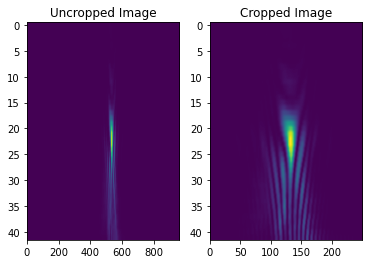

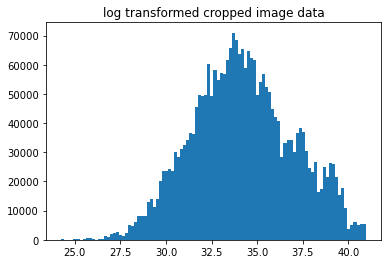

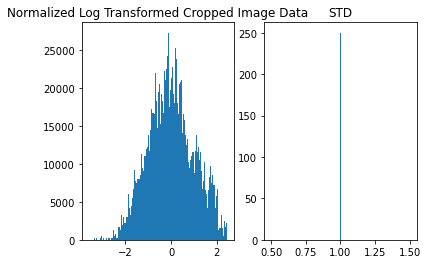

bad image count: 0
min initial beam intensity -0.00997997998


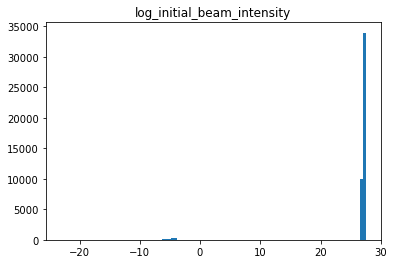

<KeysViewHDF5 ['params', 'preprocessed_beam_intensities', 'preprocessed_initial_beam_intensity', 'preprocessed_param_vals']>
<HDF5 dataset "params": shape (2,), type "|O">
[b'SSA_horizontalSize' b'SSA_verticalSize']
<HDF5 dataset "preprocessed_param_vals": shape (250, 2), type "<f4">


In [20]:
param_count, resized_images = ip.preprocess(filename)

In [21]:
# dataloaders and dataset
training_intensity_dataloader, testing_intensity_dataloader = build_dataloaders('preprocessed_results.h5', 10)

In [22]:
# define model
model = UNet(128, 128, param_count)

In [23]:
# get model summary with 128x128 size images
summary(model, input_data = (torch.ones(2, 1, 128, 128), torch.ones(2, param_count)),
        col_names=('input_size', 'output_size', 'num_params'))

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
UNet                                     --                        --                        --
├─Conv2d: 1-1                            [2, 1, 128, 128]          [2, 1, 128, 128]          10
├─Conv2d: 1-2                            [2, 1, 128, 128]          [2, 64, 128, 128]         640
├─Dropout: 1-3                           [2, 64, 128, 128]         [2, 64, 128, 128]         --
├─ReLU: 1-4                              [2, 64, 128, 128]         [2, 64, 128, 128]         --
├─Conv2d: 1-5                            [2, 64, 128, 128]         [2, 64, 128, 128]         36,928
├─MaxPool2d: 1-6                         [2, 64, 128, 128]         [2, 64, 64, 64]           --
├─Conv2d: 1-7                            [2, 64, 64, 64]           [2, 128, 64, 64]          73,856
├─Dropout: 1-8                           [2, 128, 64, 64]          [2, 128, 64, 64]          --
├─ReLU: 1-9               

In [24]:
# define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = torch.nn.MSELoss()

In [25]:
def train(model, optimizer, loss_function, train_dataloader, test_dataloader, epochs):
    '''
    Function for training the model
    '''
    train_loss = []
    test_loss = []

    if torch.cuda.is_available():
        device  = torch.device('cuda')
    else:
        device = torch.device('cpu')

    model.to(device)

    # want to visualize images and output
    num_rows = round((epochs-1)/100)
    fig, axs = plt.subplots(nrows=num_rows+1, ncols=3)
    count  = 0

    for e in range(0, epochs):
        training_loss = 0.0 
        model.train()
        for correct_images, images, input_params in train_dataloader:
            optimizer.zero_grad()
            images = images.to(device)
            correct_images = correct_images.to(device)

            predicted_images  = model(images, input_params)

            loss = loss_function(predicted_images, correct_images)
            loss.backward()
            optimizer.step()

            training_loss += loss.data.item()
        train_loss.append(training_loss)

        testing_loss = 0.0
        model.eval()

        for correct_images, images, input_params in test_dataloader:
            images = images.to(device)
            correct_images = correct_images.to(device)
            predicted_images = model(images, input_params)
            loss = loss_function(predicted_images, correct_images)
            testing_loss += loss.data.item()

        test_loss.append(testing_loss)


        if e % 100 == 0:
            print(
                'Epoch:{}, Training Loss: {:.5f}, Test Loss: {:.5f}'.format(e, training_loss, testing_loss)
                )
            images = images.numpy()
            #print(images.shape)
            axs[count, 0].imshow(images[0, 0, :, :], origin="lower")
            axs[count, 0].set_title("initial, e= "+str(e))
            axs[count,0].axis("off")
            axs[count, 1].imshow(correct_images[0, 0, :, :], origin="lower")
            axs[count, 1].set_title("target, e= "+str(e))
            axs[count, 1].axis("off")
            #axs[1].set_xlabel(radius_scale_factor[0, :])
            predicted_images = predicted_images.cpu().detach().numpy()
            axs[count, 2].imshow(predicted_images[0, 0, :, :], origin="lower")
            axs[count, 2].set_title("output, e= "+str(e))
            axs[count, 2].axis("off")
            count += 1
    return train_loss, test_loss

In [26]:
sim_count = len(resized_images)
beamline = 'TES'

epoch_count = 1001

In [27]:
print(f"training_intensity_dataloader length {len(training_intensity_dataloader)}")
print(f"testing_intensity_dataloader length {len(testing_intensity_dataloader)}")


training_intensity_dataloader length 17
testing_intensity_dataloader length 9


In [ ]:
train_loss, test_loss = train(
    model,
    optimizer,
    loss_func,
    training_intensity_dataloader,
    testing_intensity_dataloader,
    epochs = epoch_count
    )

plt.figure()
plt.plot(train_loss)
plt.title(f"{beamline} {sim_count} Simulations Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

plt.figure()
plt.plot(test_loss)
plt.title(f"{beamline} {sim_count} Simulations Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:85: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch:0, Training Loss: 18461752.98921, Test Loss: 9114258.75000
Epoch:100, Training Loss: 672142.30078, Test Loss: 256061.49609
Epoch:200, Training Loss: 680810.21289, Test Loss: 255764.35742


In [ ]:
plt.plot(train_loss)
plt.title(f"{beamline} {sim_count} Simulations Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()

plt.plot(test_loss)
plt.title(f"{beamline} {sim_count} Simulations Testing Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.show()